In [1]:
# Import libraries
import mne 
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
#from src.input_config import args
from src.preprocessing_lib import EcogReader, Epocher, parcellation_to_indices
from src.preprocessing_lib import prepare_condition_scaled_ts
from mne.time_frequency import tfr_morlet

In [3]:
# Get arguments from input_config
%run ../src/input_config.py

In [4]:
args.derivatives_path

PosixPath('../data/derivatives')

In [5]:
# Read ECoG
reader = EcogReader(args.data_path, subject=args.subject, stage=args.stage,
                         preprocessed_suffix=args.preprocessed_suffix,
                         epoch=args.epoch)
raw = reader.read_ecog()

Opening raw data file ../data/derivatives/DiAs/ieeg/DiAs_bad_chans_removed_raw.fif...
    Range : 0 ... 348212 =      0.000 ...   696.424 secs
Ready.
Reading 0 ... 348212  =      0.000 ...   696.424 secs...


In [6]:
def visual_indices(args):
    """
    Return indices of each functional group for a given subject
    Input: 
        - data_path (string): where data of cifar project is stored 
        - subject (string): subject name
    Output:
        - indices (dict): indices of each functional group
    """
    # Read visual channel dataframe
    reader = EcogReader(args.data_path, subject=args.subject)
    df_visual = reader.read_channels_info(fname=args.channels)
    # Return indices of functional groups from visual channel dataframe
    indices = parcellation_to_indices(df_visual, parcellation='group', matlab=False)
    return indices 

In [9]:
def compute_group_power(args, freqs, group='F', condition = 'Face', l_freq = 0.01,
                 baseline=(-0.5, 0), mode = 'zscore'):
    """Compute power of visually responsive epochs for time freq analysis"""
    # Read ECoG
    reader = EcogReader(args.data_path, subject=args.subject, stage=args.stage,
                         preprocessed_suffix=args.preprocessed_suffix,
                         epoch=args.epoch)
    raw = reader.read_ecog()
    # Read visually responsive channels
    df_visual = reader.read_channels_info(fname='visual_channels.csv')
    visual_chans = df_visual['chan_name'].to_list()
    raw = raw.pick_channels(visual_chans)
    # Get visual channels from functional group
    indices = visual_indices(args)
    group_indices = indices[group]
    group_chans = [visual_chans[i] for i in group_indices]
    print(f'\n {group} channels are {group_chans} \n')
    # Epoch raw ECoG
    epocher = Epocher(condition=condition, t_prestim=args.t_prestim, t_postim = args.t_postim, 
                             baseline=None, preload=True, tmin_baseline=args.tmin_baseline, 
                             tmax_baseline=args.tmax_baseline, mode=args.mode)
    epochs = epocher.epoch(raw)
    # High pass filter
    epochs = epochs.filter(l_freq=l_freq, h_freq=None)
    # Downsample
    epochs = epochs.decimate(args.decim)
    times = epochs.times
    # Pick channels
    epochs = epochs.pick(group_chans)
    # Compute time frequency with Morlet wavelet 
    n_cycles = freqs/2
    power = tfr_morlet(epochs, freqs, n_cycles, return_itc=False)
    # Apply baseline correction
    baseline = (args.tmin_baseline, args.tmax_baseline)
    print(f"\n Computing group power from morlet wavelet: rescale with {mode}")
    print(f"\n Condition is {condition}\n")
    power.apply_baseline(baseline=baseline, mode=mode)
    power = power.data
    power = np.average(power,axis=0)
    return power, times

In [10]:
# Parameters
condition = 'Face'
fn = 500/args.decim #Nyquist
nfreqs = 2**9
fmin = 0.5
fmax = fn/2 - 1
fres = (fmax + fmin -1)/nfreqs
freqs = np.arange(fmin,fmax,fres)
n_cycles = freqs/2
mode = 'zscore'
baseline = (-0.4, 0)
chan = 'LTo1-LTo2'

In [11]:
power, time = compute_group_power(args, freqs, group='F', condition = 'Face', l_freq = 0.01,
                 baseline=(-0.5, 0), mode = 'zscore')

Opening raw data file ../data/derivatives/DiAs/ieeg/DiAs_bad_chans_removed_raw.fif...
    Range : 0 ... 348212 =      0.000 ...   696.424 secs
Ready.
Reading 0 ... 348212  =      0.000 ...   696.424 secs...

 F channels are ['LGRD58-LGRD59', 'LGRD60-LGRD61', 'LTp3-LTp4', 'LTp5-LTp6'] 

Used Annotations descriptions: ['-1', '-2', 'Face010', 'Face020', 'Face030', 'Face040', 'Face050', 'Face060', 'Face070', 'Face110', 'Face120', 'Face130', 'Face140', 'Face150', 'Face160', 'Face170', 'Place010', 'Place020', 'Place030', 'Place040', 'Place050', 'Place060', 'Place070', 'Place110', 'Place120', 'Place130', 'Place140', 'Place150', 'Place160', 'Place170', 'boundary']
Not setting metadata
124 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 124 events and 1126 original time points ...
4 bad epochs dropped
Setting up high-pass filter at 0.01 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal

/tmp/ipykernel_18900/2922937351.py:24: RuntimeWarning: filter_length (165001) is longer than the signal (1126), distortion is likely. Reduce filter length or filter a longer signal.
  epochs = epochs.filter(l_freq=l_freq, h_freq=None)
/tmp/ipykernel_18900/2922937351.py:26: RuntimeWarning: The measurement information indicates a low-pass frequency of 250 Hz. The decim=2 parameter will result in a sampling frequency of 250 Hz, which can cause aliasing artifacts.
  epochs = epochs.decimate(args.decim)



 Computing group power from morlet wavelet: rescale with zscore

 Condition is Face

Applying baseline correction (mode: zscore)


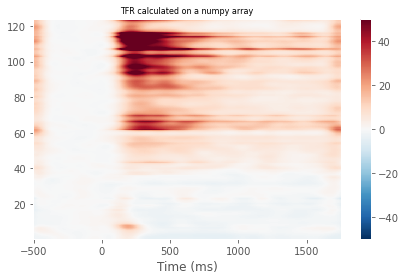

In [14]:
from mne.viz import centers_to_edges
%matplotlib inline
fig, ax = plt.subplots()
x, y = centers_to_edges(time * 1000, freqs)
mesh = ax.pcolormesh(x, y, power, cmap='RdBu_r', vmin=-50, vmax=50)
ax.set_title('TFR calculated on a numpy array')
ax.set(ylim=freqs[[0, -1]], xlabel='Time (ms)')
fig.colorbar(mesh)
plt.tight_layout()
plt.show()

In [36]:
conditions = ['Rest', 'Face', 'Place']
groups = ['R','O','F']
tf_dict = {'subject':[],'condition':[],'group':[],'power':[]}

ValueError: too many values to unpack (expected 2)

0
1
2
0
1
2
0
1
2
